# Bus Ticket Price Prediction - Production Pipeline

**Project:** ML-based price prediction for bus tickets  
**Framework:** scikit-learn 1.4.2, XGBoost with Weights & Biases monitoring

---

## Pipeline Overview

1. Data Ingestion & Validation
2. Exploratory Data Analysis
3. Data Preprocessing & Cleaning
4. Feature Engineering (24+ features)
5. Model Training (Multiple algorithms)
6. Model Evaluation & Selection
7. Model Persistence
8. W&B Dashboard Integration

## Section 1: Environment Setup

In [1]:
%%capture
# Install required packages with specific versions
!pip install pyarrow wandb xgboost python-dateutil scikit-learn==1.4.2 -q

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import json
import warnings
from datetime import datetime, timedelta
from dateutil import parser as date_parser
import logging

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import joblib
import pickle

# Weights & Biases
import wandb

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Environment setup complete.")
print(f"Python Libraries Loaded:")
print(f"  - pandas: {pd.__version__}")
print(f"  - numpy: {np.__version__}")
import sklearn
print(f"  - scikit-learn: {sklearn.__version__}")
print(f"  - xgboost: {xgb.__version__}")

Environment setup complete.
Python Libraries Loaded:
  - pandas: 2.3.3
  - numpy: 2.4.1
  - scikit-learn: 1.4.2
  - xgboost: 3.1.3


## Section 2: Weights & Biases Initialization

In [3]:
# Initialize Weights & Biases
print("Initializing Weights & Biases...")
print("Please enter your W&B API key when prompted.")
print("Get your key from: https://wandb.ai/authorize")

wandb.login()

# Initialize W&B run
run = wandb.init(
    project="bus-price-prediction",
    name=f"training-run-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
    config={
        "model_family": "ensemble",
        "algorithms": ["LinearRegression", "RandomForest", "XGBoost", "GradientBoosting"],
        "test_size": 0.2,
        "random_state": RANDOM_STATE,
        "feature_engineering": "advanced",
        "sklearn_version": "1.4.2"
    },
    tags=["production", "bus-tickets", "price-prediction"]
)

config = wandb.config
print(f"\nW&B Run initialized: {run.name}")
print(f"Dashboard URL: {run.url}")

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from C:\Users\Arn\_netrc.


Initializing Weights & Biases...
Please enter your W&B API key when prompted.
Get your key from: https://wandb.ai/authorize


wandb: Currently logged in as: niharikareddy6902 (niharikareddy6902-arnsofttech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



W&B Run initialized: training-run-20260127-104102
Dashboard URL: https://wandb.ai/niharikareddy6902-arnsofttech/bus-price-prediction/runs/lhjrsc4o


## Section 3: Data Ingestion

In [4]:
import os
print(os.getcwd())
os.path.exists("./all_data_parquet")  # True/False
os.listdir("./")  # S

c:\Users\Arn\Projects\dynamic-pricing\notebooks


['DP_parquet (3).ipynb', 'DP_parquet.ipynb', 'dp_parquet2.ipynb', 'wandb']

In [5]:
import os
import glob

# Find all matching files
files_to_delete = sorted(glob.glob("data_part*.parquet"))

if not files_to_delete:
    print("No data_part*.parquet files found in the current directory.")
    print("→ You can safely upload new files now.")
else:
    print(f"Found {len(files_to_delete)} existing Parquet file(s):")
    for i, f in enumerate(files_to_delete, 1):
        print(f"  {i:2d}. {f}")

    print("\nThese files will be **permanently deleted** if you continue.")
    print("This is useful before uploading new files with the same names to avoid (1), (2), ... suffixes.")

    # Ask for confirmation
    confirm = input("\nDo you want to delete all these files? (yes/no): ").strip().lower()

    if confirm in ['yes', 'y', 'ok', 'delete']:
        deleted_count = 0
        for f in files_to_delete:
            try:
                os.remove(f)
                print(f"Deleted: {f}")
                deleted_count += 1
            except Exception as e:
                print(f"Failed to delete {f}: {e}")

        print(f"\nCleanup complete. Deleted {deleted_count} file(s).")
        print("→ Ready for fresh upload.")
    else:
        print("\nDeletion cancelled. Files were NOT deleted.")
        print("→ You can still upload, but may get (1), (2), ... suffixes if names conflict.")

No data_part*.parquet files found in the current directory.
→ You can safely upload new files now.


In [6]:
import pandas as pd
import logging
import wandb
import glob
import os
import random  # For optional random selection

# Initialize logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

# Configurable parameters (tweak these as needed)
data_dir = "../data/complete_data"  # Relative path from notebooks/ to data/complete_data
num_files_to_load = 5               # Start with 4-5; increase later
sample_fraction = 0.1               # Optional: Load only X% of rows per file (1.0 = all)
random_select = False               # If True, pick random files instead of first N
specific_files = None               # Optional: List like ['part_001.parquet', 'part_002.parquet'] to load exactly these

# Step 1: Discover Parquet files
all_files = glob.glob(os.path.join(data_dir, "*.parquet"))
if not all_files:
    raise FileNotFoundError(f"No .parquet files found in {data_dir}")

logger.info(f"Found {len(all_files)} Parquet files in {data_dir}")

# Step 2: Select subset of files
if specific_files:
    selected_files = [os.path.join(data_dir, f) for f in specific_files if os.path.exists(os.path.join(data_dir, f))]
elif random_select:
    selected_files = random.sample(all_files, min(num_files_to_load, len(all_files)))
else:
    selected_files = sorted(all_files)[:num_files_to_load]  # Sorted for reproducibility; take first N

if not selected_files:
    raise ValueError("No files selected to load")

logger.info(f"Selected {len(selected_files)} file(s): {[os.path.basename(f) for f in selected_files]}")

# Step 3: Load into DataFrames (with optional sampling)
dfs = []
for f in selected_files:
    df = pd.read_parquet(f)
    if sample_fraction < 1.0:
        df = df.sample(frac=sample_fraction, random_state=42)  # Reproducible sampling
    dfs.append(df)
    logger.info(f"Loaded {f} with {len(df)} rows (after sampling)")

# Step 4: Combine
combined_df = pd.concat(dfs, ignore_index=True)
logger.info(f"Combined DataFrame shape: {combined_df.shape}")

# Step 5: Log to W&B
wandb.log({
    "num_loaded_files": len(selected_files),
    "file_names": [os.path.basename(f) for f in selected_files],
    "total_rows": len(combined_df),
    "sample_fraction": sample_fraction
})
# Make it available to next cells
uploaded_files = selected_files
print("Exported selected_files → as 'uploaded_files' for parser cell")

print("Data loaded successfully!")

2026-01-27 10:41:07,583 - INFO - Found 182 Parquet files in ../data/complete_data
2026-01-27 10:41:07,585 - INFO - Selected 5 file(s): ['data_part_0.parquet', 'data_part_1.parquet', 'data_part_10.parquet', 'data_part_100.parquet', 'data_part_101.parquet']
2026-01-27 10:41:08,389 - INFO - Loaded ../data/complete_data\data_part_0.parquet with 10000 rows (after sampling)
2026-01-27 10:41:08,506 - INFO - Loaded ../data/complete_data\data_part_1.parquet with 10000 rows (after sampling)
2026-01-27 10:41:08,621 - INFO - Loaded ../data/complete_data\data_part_10.parquet with 10000 rows (after sampling)
2026-01-27 10:41:08,727 - INFO - Loaded ../data/complete_data\data_part_100.parquet with 10000 rows (after sampling)
2026-01-27 10:41:08,829 - INFO - Loaded ../data/complete_data\data_part_101.parquet with 10000 rows (after sampling)
2026-01-27 10:41:08,836 - INFO - Combined DataFrame shape: (50000, 27)


Exported selected_files → as 'uploaded_files' for parser cell
Data loaded successfully!


## Section 4: Data Parser

In [7]:
import pandas as pd
import logging
from dateutil import parser as date_parser
import wandb


class BusSeatParquetParser:
    """
    Parser for seat-level Parquet data (2025–2026 schema).
    Each row represents ONE seat.
    Adapted to current exporter structure:
    - Uses source_collection instead of source_name / destination_name
    - No num_boarding_points, num_dropping_points, insurance_enabled, etc.
    - Seat-level fields: is_upper, is_ladiesSeat, is_horizontal, is_available (if present)
    """

    def __init__(self):
        self.logger = logging.getLogger(self.__class__.__name__)

    # -------------------------
    # Safe parsing helpers
    # -------------------------
    @staticmethod
    def parse_datetime(value):
        if value is None or pd.isna(value):
            return None
        try:
            return date_parser.parse(str(value))
        except Exception:
            return None

    @staticmethod
    def safe_int(value, default=0):
        try:
            return int(value)
        except (ValueError, TypeError):
            return default

    @staticmethod
    def safe_float(value, default=0.0):
        try:
            return float(value)
        except (ValueError, TypeError):
            return default

    # -------------------------
    # Seat-level price logic
    # -------------------------
    @staticmethod
    def extract_price(df):
        """
        Priority (current schema):
        1. seat_salePrice     (if > 0)
        2. seat_purchasePrice (if > 0)
        3. seat_purchasePrice + seat_tax
        """
        # Start with sale price, treat missing/NaN as 0
        price = df["seat_salePrice"].fillna(0).astype(float)

        # Where sale price is invalid (<=0), use purchase price
        use_purchase = price <= 0
        price = price.where(~use_purchase, df["seat_purchasePrice"].fillna(0))

        # Where still invalid, add tax (only if purchase was present)
        use_tax_addition = (price <= 0) & df["seat_purchasePrice"].notna() & df["seat_tax"].notna()
        price = price.where(~use_tax_addition,
                            (df["seat_purchasePrice"] + df["seat_tax"].fillna(0)))

        # Optional: floor very small nonsense values (uncomment if needed)
        # price = price.where(price >= 10, 0)

        return price

    # -------------------------
    # Main parquet parser
    # -------------------------
    def parse_parquet_files(self, file_list):
        self.logger.info(f"Parsing {len(file_list)} parquet files")

        dfs = []
        for filepath in file_list:
            try:
                df = pd.read_parquet(filepath)
                self.logger.info(f"Loaded {filepath} with {len(df)} rows")
                dfs.append(df)
            except Exception as e:
                self.logger.error(f"Error loading {filepath}: {str(e)}")

        if not dfs:
            raise ValueError("No parquet files could be loaded")

        df = pd.concat(dfs, ignore_index=True)
        self.logger.info(f"Total rows loaded: {len(df)}")

        # -------------------------
        # Datetime parsing
        # -------------------------
        df["departure_time"] = df["departureTime"].apply(self.parse_datetime)
        df["arrival_time"]   = df["arrivalTime"].apply(self.parse_datetime)
        df["journey_date"]   = df["doj"].apply(self.parse_datetime)

        # -------------------------
        # Numeric normalization
        # -------------------------
        df["available_seats"] = df["availableSeats"].apply(self.safe_int)
        df["window_seats"]    = df["avlWindowSeats"].apply(self.safe_int)

        df["is_AC"] = df["is_AC"].astype(bool)

        # -------------------------
        # Price extraction
        # -------------------------
        df["price"] = self.extract_price(df)

        # -------------------------
        # Seat-level boolean flags
        # -------------------------
        # Safely convert – use .get() to avoid KeyError if column missing
        df["seat_is_upper"]      = df.get("seat_is_upper", False).astype(bool)
        df["seat_is_ladies"]     = df.get("seat_is_ladiesSeat", False).astype(bool)
        df["seat_is_horizontal"] = df.get("seat_is_horizontal", False).astype(bool)
        df["seat_is_available"]  = df.get("seat_is_available", True).astype(bool)   # assume available if missing

        # -------------------------
        # Column standardization
        # -------------------------
        df.rename(columns={
            "id":           "bus_id",
            "providerId":   "provider_id",
            "travels":      "operator_name",
            "busType":      "bus_type",
            "name":         "seat_name",           # most common seat identifier
        }, inplace=True)

        # -------------------------
        # Final selected columns
        # -------------------------
        final_columns = [
            "bus_id",
            "provider_id",
            "scraped_time",
            "journey_date",
            "departure_time",
            "arrival_time",
            "source_collection",       # ← main source-destination info
            "bus_type",
            "is_AC",
            "available_seats",
            "window_seats",
            "operator_name",
            "seat_name",
            "seat_is_upper",
            "seat_is_ladies",
            "seat_is_horizontal",
            "seat_is_available",
            "price",
            # Optional debug / raw price columns (uncomment if needed)
            # "seat_salePrice",
            # "seat_purchasePrice",
            # "seat_tax",
        ]

        # Keep only columns that actually exist in the data
        existing_cols = [c for c in final_columns if c in df.columns]
        df_final = df[existing_cols].copy()

        # -------------------------
        # Final logging
        # -------------------------
        valid_prices = (df_final["price"].notna() & (df_final["price"] > 0)).sum()
        total_rows   = len(df_final)

        self.logger.info(
            f"Valid positive prices: {valid_prices}/{total_rows} "
            f"({valid_prices / total_rows * 100:.1f}%)"
        )

        return df_final


# -------------------------
# Run the parser using ONLY the uploaded_files from the previous cell
# -------------------------
try:
    # uploaded_files should be defined from the upload cell
    print(f"\nUsing {len(uploaded_files)} uploaded files from ingestion: {uploaded_files[:5]} ...")
except NameError:
    raise ValueError("Run the upload/ingestion cell first to define 'uploaded_files'.")

parser = BusSeatParquetParser()

print("\nParsing uploaded parquet files...")
df_raw = parser.parse_parquet_files(uploaded_files)

print("\nData Ingestion Summary:")
print(f"  Total Records: {len(df_raw)}")
print(f"  Columns: {len(df_raw.columns)}")
print(f"  Memory Usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

valid_prices = (df_raw["price"].notna() & (df_raw["price"] > 0)).sum()
print(
    f"  Valid Positive Prices: {valid_prices} "
    f"({valid_prices / len(df_raw) * 100:.1f}%)"
)

# Log to W&B
wandb.log({
    "raw_data_records": len(df_raw),
    "raw_data_columns": len(df_raw.columns),
    "valid_prices_count": int(valid_prices),
    "valid_prices_percentage": float(valid_prices / len(df_raw) * 100 if len(df_raw) > 0 else 0)
})

print("\nSample Data (first 10 rows):")
sample_cols = ["source_collection", "bus_type", "operator_name",
               "available_seats", "seat_name", "price", "seat_is_upper",
               "seat_is_ladies", "seat_is_horizontal", "seat_is_available"]
print(df_raw[ [c for c in sample_cols if c in df_raw.columns] ].head(10))

2026-01-27 10:41:08,887 - INFO - Parsing 5 parquet files
2026-01-27 10:41:08,978 - INFO - Loaded ../data/complete_data\data_part_0.parquet with 100000 rows



Using 5 uploaded files from ingestion: ['../data/complete_data\\data_part_0.parquet', '../data/complete_data\\data_part_1.parquet', '../data/complete_data\\data_part_10.parquet', '../data/complete_data\\data_part_100.parquet', '../data/complete_data\\data_part_101.parquet'] ...

Parsing uploaded parquet files...


2026-01-27 10:41:09,061 - INFO - Loaded ../data/complete_data\data_part_1.parquet with 100000 rows
2026-01-27 10:41:09,146 - INFO - Loaded ../data/complete_data\data_part_10.parquet with 100000 rows
2026-01-27 10:41:09,229 - INFO - Loaded ../data/complete_data\data_part_100.parquet with 100000 rows
2026-01-27 10:41:09,320 - INFO - Loaded ../data/complete_data\data_part_101.parquet with 100000 rows
2026-01-27 10:41:09,353 - INFO - Total rows loaded: 500000
2026-01-27 10:42:32,100 - INFO - Valid positive prices: 500000/500000 (100.0%)



Data Ingestion Summary:
  Total Records: 500000
  Columns: 18
  Memory Usage: 334.50 MB
  Valid Positive Prices: 500000 (100.0%)

Sample Data (first 10 rows):
     source_collection                                      bus_type  \
0  hyderabad_bangalore  Volvo A/C B11R Multi Axle Semi Sleeper (2+2)   
1  hyderabad_bangalore  Volvo A/C B11R Multi Axle Semi Sleeper (2+2)   
2  hyderabad_bangalore  Volvo A/C B11R Multi Axle Semi Sleeper (2+2)   
3  hyderabad_bangalore  Volvo A/C B11R Multi Axle Semi Sleeper (2+2)   
4  hyderabad_bangalore  Volvo A/C B11R Multi Axle Semi Sleeper (2+2)   
5  hyderabad_bangalore  Volvo A/C B11R Multi Axle Semi Sleeper (2+2)   
6  hyderabad_bangalore  Volvo A/C B11R Multi Axle Semi Sleeper (2+2)   
7  hyderabad_bangalore  Volvo A/C B11R Multi Axle Semi Sleeper (2+2)   
8  hyderabad_bangalore  Volvo A/C B11R Multi Axle Semi Sleeper (2+2)   
9  hyderabad_bangalore  Volvo A/C B11R Multi Axle Semi Sleeper (2+2)   

     operator_name  available_seats seat_name  

## Section 5: Exploratory Data Analysis

Dataset shape: (500000, 18)
Date of analysis: 2026-01-27 10:42 IST

1. Basic Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   bus_id              500000 non-null  object        
 1   provider_id         500000 non-null  object        
 2   scraped_time        500000 non-null  object        
 3   journey_date        500000 non-null  object        
 4   departure_time      500000 non-null  object        
 5   arrival_time        500000 non-null  datetime64[ns]
 6   source_collection   500000 non-null  object        
 7   bus_type            500000 non-null  object        
 8   is_AC               500000 non-null  bool          
 9   available_seats     500000 non-null  int64         
 10  window_seats        500000 non-null  int64         
 11  operator_name       500000 non-null  object        
 1

None


Missing values (%):


Series([], dtype: float64)


2. Categorical Distributions


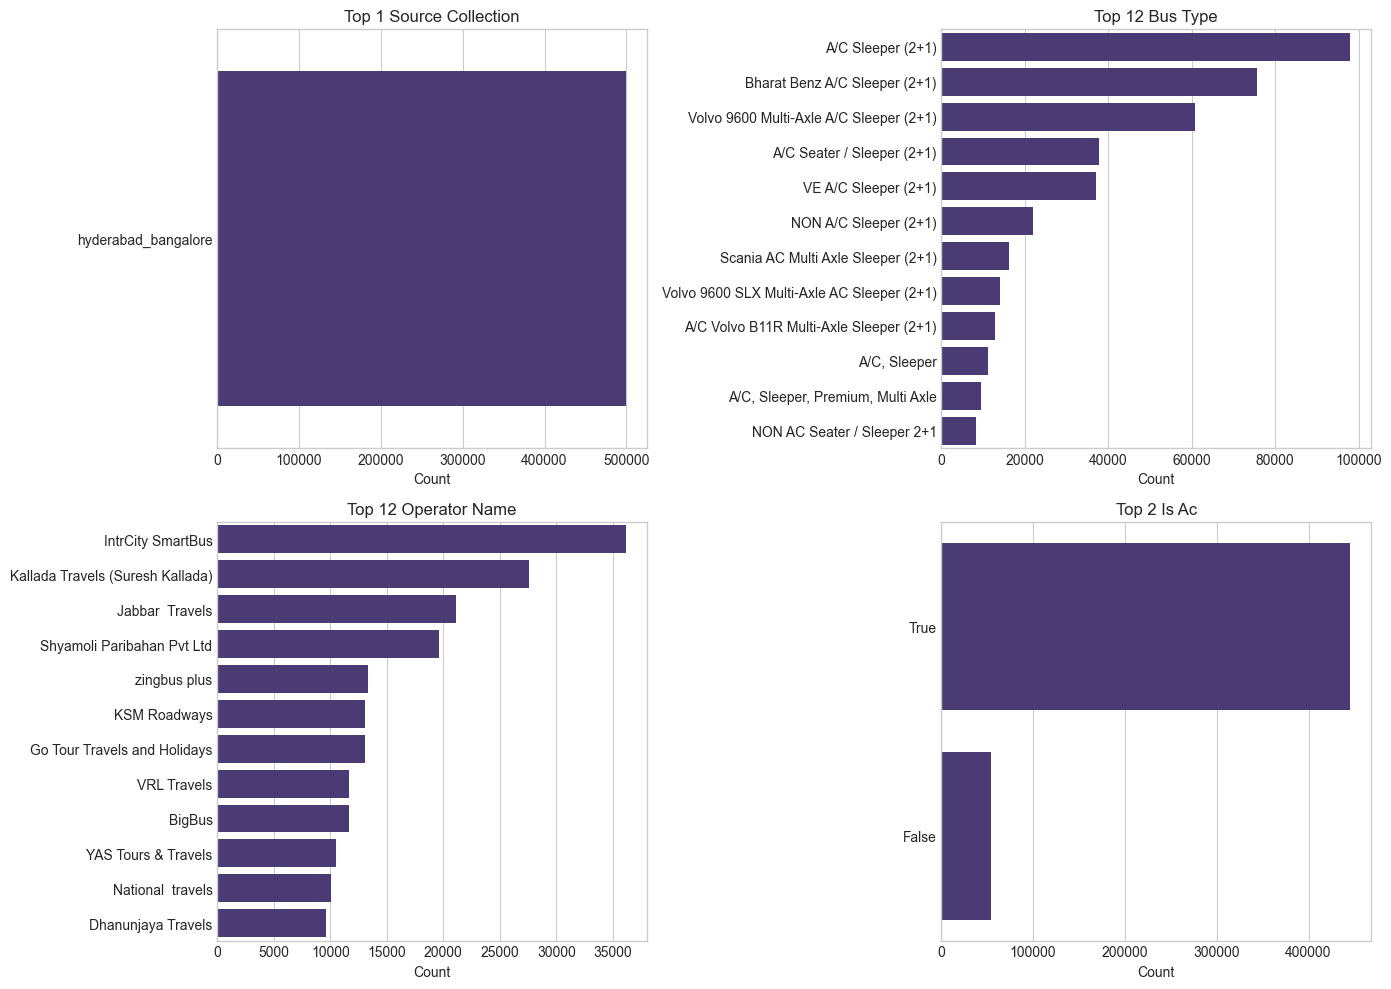


3. Numerical Features


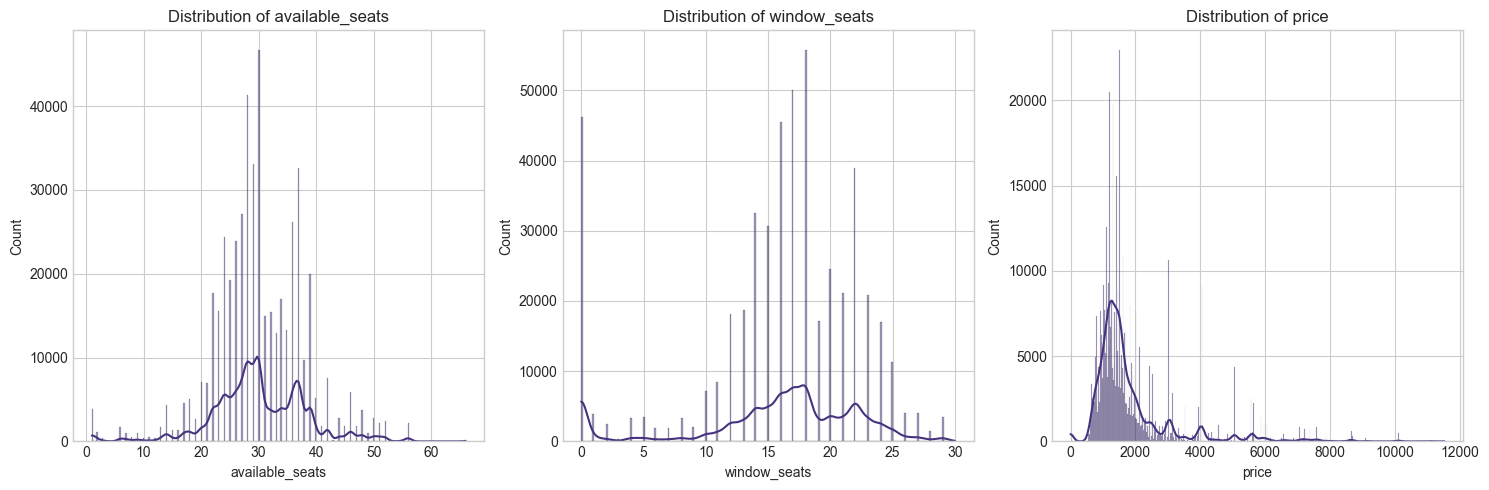

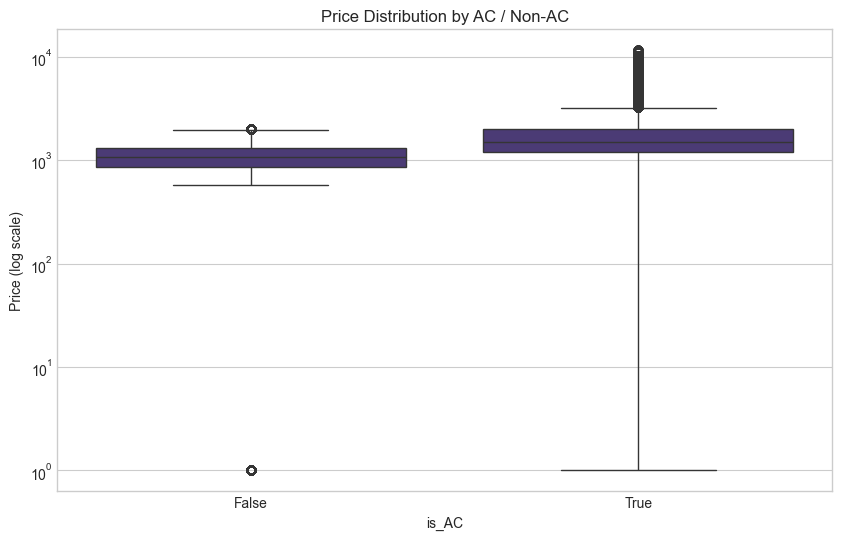


4. Seat-level Boolean Flags


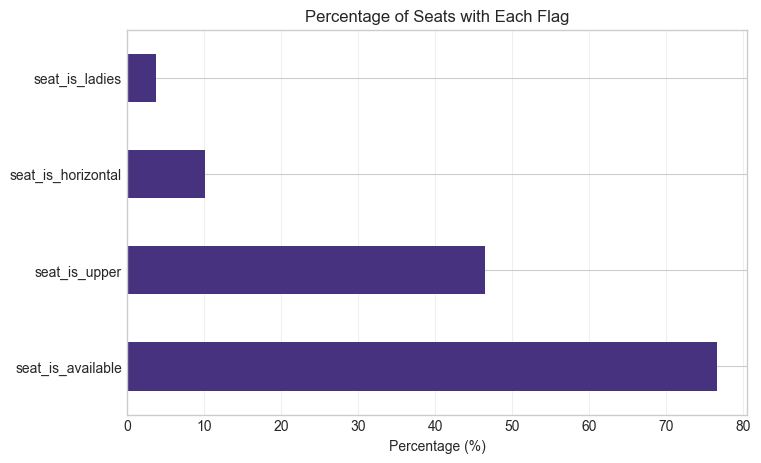

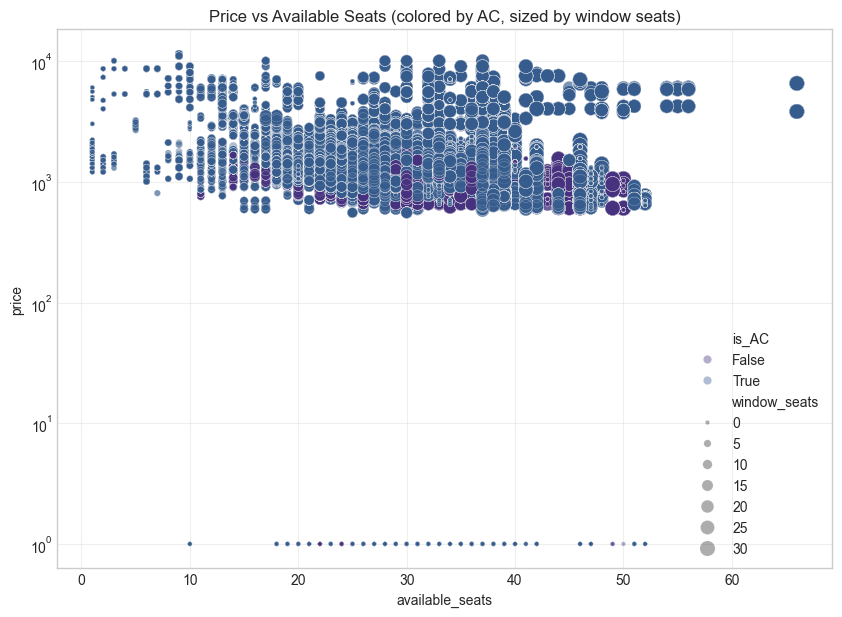


6. Top 8 most expensive & cheapest routes (median price)

Most expensive routes (median price):


,median,count,mean
source_collection,,,
hyderabad_bangalore,1435.0,500000,1810.0



Cheapest routes (median price):


,median,count,mean
source_collection,,,
hyderabad_bangalore,1435.0,500000,1810.0


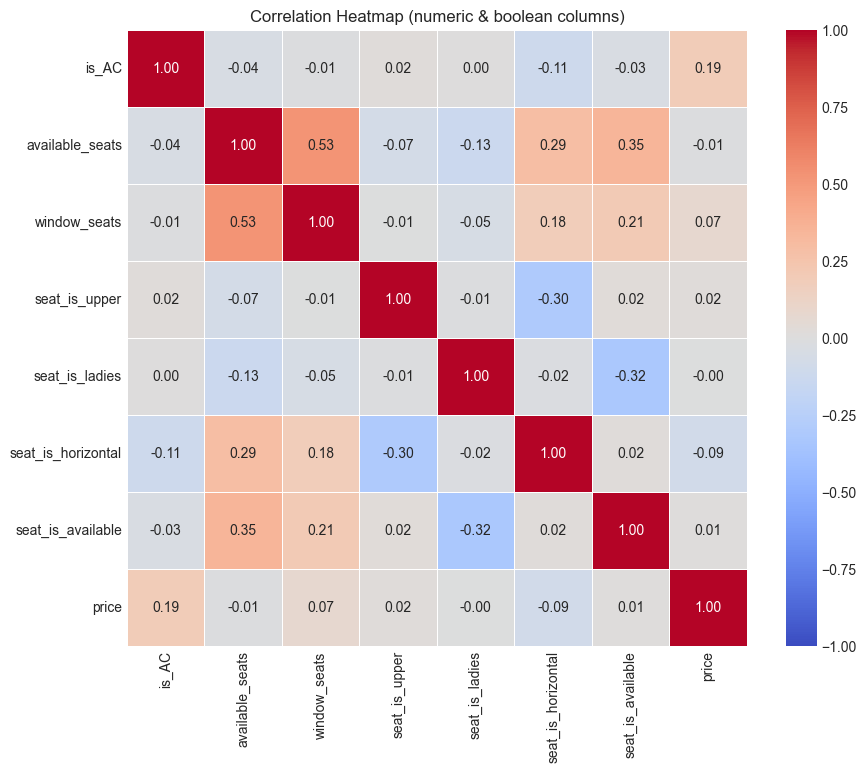


EDA complete.


In [8]:
# ──────────────────────────────────────────────
#          EDA - Bus Seat Level Data (New Schema 2025–2026)
# ──────────────────────────────────────────────

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# ── Styling ────────────────────────────────────────
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
%matplotlib inline

print(f"Dataset shape: {df_raw.shape}")
print(f"Date of analysis: {datetime.now().strftime('%Y-%m-%d %H:%M IST')}")

# ── 1. Basic overview ─────────────────────────────────
print("\n" + "="*60)
print("1. Basic Information")
print("="*60)
display(df_raw.info())

print("\nMissing values (%):")
missing = df_raw.isna().mean().sort_values(ascending=False) * 100
display(missing[missing > 0].round(2))

# ── 2. Key categorical distributions ──────────────────
print("\n" + "="*60)
print("2. Categorical Distributions")
print("="*60)

cat_cols = ['source_collection', 'bus_type', 'operator_name', 'is_AC']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, col in enumerate(cat_cols):
    if col in df_raw.columns:
        top_n = df_raw[col].value_counts().nlargest(12)
        sns.countplot(y=df_raw[col], order=top_n.index, ax=axes[i])
        axes[i].set_title(f"Top {len(top_n)} {col.replace('_', ' ').title()}")
        axes[i].set_xlabel("Count")
        axes[i].set_ylabel("")
    else:
        axes[i].text(0.5, 0.5, f"Column '{col}' not found",
                     ha='center', va='center', fontsize=12)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

# ── 3. Numerical distributions ────────────────────────
print("\n" + "="*60)
print("3. Numerical Features")
print("="*60)

num_cols = ['available_seats', 'window_seats', 'price']

fig, axes = plt.subplots(1, len(num_cols), figsize=(15, 5))

for i, col in enumerate(num_cols):
    if col in df_raw.columns:
        sns.histplot(df_raw[col].dropna(), kde=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {col}")
        axes[i].set_xlabel(col)
    else:
        axes[i].text(0.5, 0.5, f"Column '{col}' missing", ha='center', va='center')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

# Price by AC / non-AC
if 'price' in df_raw.columns and 'is_AC' in df_raw.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='is_AC', y='price', data=df_raw)
    plt.title("Price Distribution by AC / Non-AC")
    plt.yscale('log')
    plt.ylabel("Price (log scale)")
    plt.show()

# ── 4. Seat level flags ───────────────────────────────
print("\n" + "="*60)
print("4. Seat-level Boolean Flags")
print("="*60)

seat_flags = ['seat_is_upper', 'seat_is_ladies', 'seat_is_horizontal', 'seat_is_available']

flag_sums = {}
for flag in seat_flags:
    if flag in df_raw.columns:
        flag_sums[flag] = df_raw[flag].mean() * 100

if flag_sums:
    pd.Series(flag_sums).sort_values(ascending=False).plot(kind='barh', figsize=(8,5))
    plt.title("Percentage of Seats with Each Flag")
    plt.xlabel("Percentage (%)")
    plt.grid(axis='x', alpha=0.3)
    plt.show()
else:
    print("No seat-level flag columns found in current data.")

# ── 5. Price vs Availability (scatter / hex) ──────────
if all(c in df_raw.columns for c in ['available_seats', 'price']):
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df_raw, x='available_seats', y='price',
                    alpha=0.4, hue='is_AC', size='window_seats',
                    sizes=(10, 120))
    plt.title("Price vs Available Seats (colored by AC, sized by window seats)")
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.show()

# ── 6. Top expensive / cheap seats per route ──────────
print("\n" + "="*60)
print("6. Top 8 most expensive & cheapest routes (median price)")
print("="*60)

if 'price' in df_raw.columns and 'source_collection' in df_raw.columns:
    route_price = df_raw.groupby('source_collection')['price'].agg(['median','count','mean'])
    route_price = route_price[route_price['count'] >= 50].sort_values('median', ascending=False)

    print("\nMost expensive routes (median price):")
    display(route_price.head(8).round(0))

    print("\nCheapest routes (median price):")
    display(route_price.tail(8).round(0))

# ── 7. Quick correlation heatmap (numeric only) ───────
numeric_df = df_raw.select_dtypes(include=['number', 'bool'])
if not numeric_df.empty and len(numeric_df.columns) > 1:
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f",
                linewidths=0.5, vmin=-1, vmax=1)
    plt.title("Correlation Heatmap (numeric & boolean columns)")
    plt.show()
else:
    print("Not enough numeric columns for correlation heatmap.")

print("\nEDA complete.")

## Section 6: Data Preprocessing

Starting preprocessing with 500,000 rows

Preprocessing Summary:
  Duplicates Removed       : 0
  Invalid Removed          : 5790
  Outliers Removed         : 50339
  Retention Pct            : 88.8


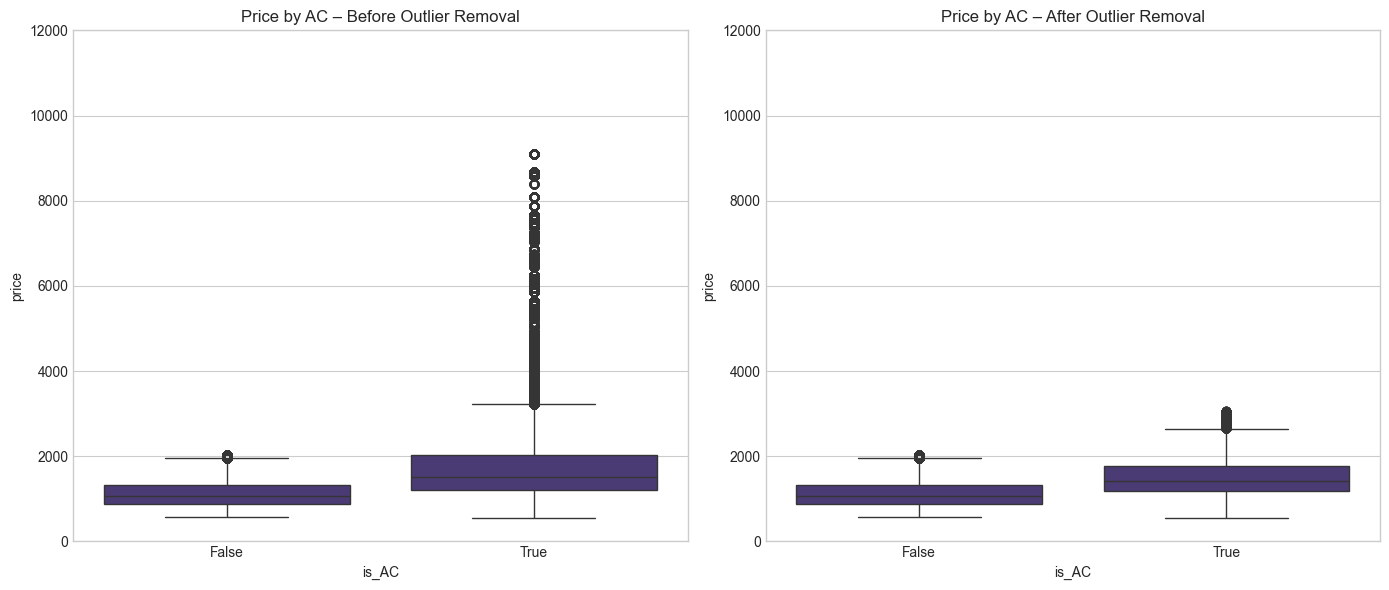


After Preprocessing – Shape: (443871, 24)
New columns added: ['days_to_journey', 'duration_hours', 'hours_to_departure', 'journey_weekday', 'price_log', 'scrape_hour']


,bus_id,provider_id,scraped_time,journey_date,departure_time,arrival_time,source_collection,bus_type,is_AC,available_seats,window_seats,operator_name,seat_name,seat_is_upper,seat_is_ladies,seat_is_horizontal,seat_is_available,price,hours_to_departure,duration_hours,days_to_journey,scrape_hour,journey_weekday,price_log
0,1000005754604920815,8NXRaB0$3ZPutvSDqHQPaB0$LuzQaC0$aC0$,2025-12-07 17:11:00.819135+05:30,2025-12-13 00:00:00+05:30,2025-12-14 04:00:00+05:30,2025-12-14 15:00:00+05:30,hyderabad_bangalore,Volvo A/C B11R Multi Axle Semi Sleeper (2+2),True,45,21,Jabbar Travels,D1,False,False,True,True,794.0,154.82,11.0,6,17,5,6.68
1,1000005754604920815,8NXRaB0$3ZPutvSDqHQPaB0$LuzQaC0$aC0$,2025-12-07 17:11:00.819135+05:30,2025-12-13 00:00:00+05:30,2025-12-14 04:00:00+05:30,2025-12-14 15:00:00+05:30,hyderabad_bangalore,Volvo A/C B11R Multi Axle Semi Sleeper (2+2),True,45,21,Jabbar Travels,D2,False,False,True,True,753.0,154.82,11.0,6,17,5,6.63
2,1000005754604920815,8NXRaB0$3ZPutvSDqHQPaB0$LuzQaC0$aC0$,2025-12-07 17:11:00.819135+05:30,2025-12-13 00:00:00+05:30,2025-12-14 04:00:00+05:30,2025-12-14 15:00:00+05:30,hyderabad_bangalore,Volvo A/C B11R Multi Axle Semi Sleeper (2+2),True,45,21,Jabbar Travels,D3,False,False,True,True,861.0,154.82,11.0,6,17,5,6.76


In [9]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

sns.set_style("whitegrid")
logging.basicConfig(level=logging.INFO)

class BusSeatPreprocessor:
    def __init__(self, min_price=100, max_price=10000, outlier_method='iqr_1.5', drop_outliers=True):
        self.logger = logging.getLogger(self.__class__.__name__)
        self.stats = {}
        self.min_price = min_price
        self.max_price = max_price
        self.outlier_method = outlier_method
        self.drop_outliers = drop_outliers

    def remove_duplicates(self, df):
        n = len(df)
        df = df.drop_duplicates(subset=['bus_id', 'seat_name', 'journey_date', 'scraped_time'])
        self.stats['duplicates_removed'] = n - len(df)
        return df

    def clean_invalid(self, df):
        n = len(df)
        df = df[(df['available_seats'] >= 0) & (df['window_seats'] >= 0)]
        df = df[df['window_seats'] <= df['available_seats']]
        df = df[df['price'].between(self.min_price, self.max_price)]
        self.stats['invalid_removed'] = n - len(df)
        return df

    def remove_price_outliers(self, df):
        n_before = len(df)
        if self.outlier_method == 'iqr_1.5':
            Q1 = df['price'].quantile(0.25)
            Q3 = df['price'].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            mask = (df['price'] >= lower) & (df['price'] <= upper)
        elif self.outlier_method == 'iqr_3':
            Q1 = df['price'].quantile(0.25)
            Q3 = df['price'].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 3 * IQR
            upper = Q3 + 3 * IQR
            mask = (df['price'] >= lower) & (df['price'] <= upper)
        else:
            mask = pd.Series(True, index=df.index)

        if self.drop_outliers:
            df = df[mask]
            self.stats['outliers_removed'] = n_before - len(df)
        return df

    def add_basic_time_features(self, df):
        IST = pytz.timezone('Asia/Kolkata')

        for col in ['scraped_time', 'departure_time', 'arrival_time', 'journey_date']:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)
                if df[col].dt.tz is None:
                    df[col] = df[col].dt.tz_localize(IST)
                else:
                    df[col] = df[col].dt.tz_convert(IST)

        # Basic time differences
        if all(c in df for c in ['departure_time', 'scraped_time']):
            df['hours_to_departure'] = ((df['departure_time'] - df['scraped_time']).dt.total_seconds() / 3600).clip(lower=0)

        if all(c in df for c in ['arrival_time', 'departure_time']):
            df['duration_hours'] = ((df['arrival_time'] - df['departure_time']).dt.total_seconds() / 3600).clip(lower=0)

        if all(c in df for c in ['journey_date', 'scraped_time']):
            df['days_to_journey'] = ((df['journey_date'].dt.floor('D') - df['scraped_time'].dt.floor('D')).dt.days).clip(lower=0)

        # Basic extractions
        if 'scraped_time' in df:
            df['scrape_hour'] = df['scraped_time'].dt.hour

        if 'journey_date' in df:
            df['journey_weekday'] = df['journey_date'].dt.weekday

        df['price_log'] = np.log1p(df['price'])

        return df

    def plot_price_before_after(self, df_raw, df_clean):
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))
        sns.boxplot(data=df_raw, x='is_AC', y='price', ax=ax[0])
        ax[0].set_title("Price by AC – Before Outlier Removal")
        ax[0].set_ylim(0, 12000)

        sns.boxplot(data=df_clean, x='is_AC', y='price', ax=ax[1])
        ax[1].set_title("Price by AC – After Outlier Removal")
        ax[1].set_ylim(0, 12000)

        plt.tight_layout()
        plt.show()

    def run(self, df_raw):
        df = df_raw.copy()
        n_start = len(df)
        print(f"Starting preprocessing with {n_start:,} rows")

        df = self.remove_duplicates(df)
        df = self.clean_invalid(df)
        df_before_outliers = df.copy()  # save for plot
        df = self.remove_price_outliers(df)
        df = self.add_basic_time_features(df)

        n_end = len(df)
        self.stats['retention_pct'] = round(n_end / n_start * 100, 1)

        print("\nPreprocessing Summary:")
        for k, v in self.stats.items():
            print(f"  {k.replace('_',' ').title():<25}: {v}")

        # Show boxplot comparison
        self.plot_price_before_after(df_before_outliers, df)

        print(f"\nAfter Preprocessing – Shape: {df.shape}")
        new_cols = set(df.columns) - set(df_raw.columns)
        print(f"New columns added: {sorted(new_cols)}")

        return df


# ── Execute Preprocessing ────────────────────────────────────────
preprocessor = BusSeatPreprocessor(min_price=100, max_price=10000, outlier_method='iqr_1.5', drop_outliers=True)
df_clean = preprocessor.run(df_raw.copy())

display(df_clean.head(3))

## Section 7: Feature Engineering

In [10]:
import pandas as pd
import numpy as np

class BusPriceFeatureEngineer:
    def create_features(self, df):
        df = df.copy()
        # Preserve scraped_time for time-based split later
        if 'scraped_time' in df.columns:
            df['scraped_time'] = df['scraped_time']  # just ensure it's kept
        print(f"Starting Feature Engineering with shape: {df.shape}")

        # Temporal patterns (using already created basic features)
        df['journey_is_weekend'] = df['journey_weekday'].isin([5, 6]).astype(int)
        df['is_night_departure'] = df['departure_time'].dt.hour.between(20, 5).astype(int)

        # Binned versions for non-linear effects
        df['hours_to_departure_bin'] = pd.cut(df['hours_to_departure'],
                                              bins=[-1, 6, 12, 24, 48, 72, 168, np.inf],
                                              labels=['<6h', '6-12h', '12-24h', '1-2d', '2-3d', '3-7d', '>7d'])

        # Demand & scarcity signals
        df['low_availability'] = (df['available_seats'] <= 5).astype(int)
        df['very_low_availability'] = (df['available_seats'] <= 2).astype(int)
        df['seats_sold_ratio'] = 1 - (df['available_seats'] / 50).clip(upper=1)  # assume ~50 seats avg

        # Seat preference / desirability
        df['is_lower_berth'] = (~df['seat_is_upper']).astype(int)
        df['is_premium_seat'] = (df['is_lower_berth'] & (df['window_seats'] > 0)).astype(int)

        # Additional bus flags
        df['is_volvo'] = df['bus_type'].str.contains('volvo', case=False, na=False).astype(int)

        new_cols = sorted(set(df.columns) - set(df_clean.columns))
        print(f"Feature Engineering complete. Shape: {df.shape}")
        print(f"New columns added: {new_cols}")

        return df


# ── Execute Feature Engineering ──────────────────────────────────
fe = BusPriceFeatureEngineer()
df_features = fe.create_features(df_clean.copy())

print("\nAfter Feature Engineering:")
print(f"Shape: {df_features.shape}")
print(f"New columns: {sorted(set(df_features.columns) - set(df_clean.columns))}")
display(df_features.head(3))

Starting Feature Engineering with shape: (443871, 24)
Feature Engineering complete. Shape: (443871, 33)
New columns added: ['hours_to_departure_bin', 'is_lower_berth', 'is_night_departure', 'is_premium_seat', 'is_volvo', 'journey_is_weekend', 'low_availability', 'seats_sold_ratio', 'very_low_availability']

After Feature Engineering:
Shape: (443871, 33)
New columns: ['hours_to_departure_bin', 'is_lower_berth', 'is_night_departure', 'is_premium_seat', 'is_volvo', 'journey_is_weekend', 'low_availability', 'seats_sold_ratio', 'very_low_availability']


,bus_id,provider_id,scraped_time,journey_date,departure_time,arrival_time,source_collection,bus_type,is_AC,available_seats,window_seats,operator_name,seat_name,seat_is_upper,seat_is_ladies,seat_is_horizontal,seat_is_available,price,hours_to_departure,duration_hours,days_to_journey,scrape_hour,journey_weekday,price_log,journey_is_weekend,is_night_departure,hours_to_departure_bin,low_availability,very_low_availability,seats_sold_ratio,is_lower_berth,is_premium_seat,is_volvo
0,1000005754604920815,8NXRaB0$3ZPutvSDqHQPaB0$LuzQaC0$aC0$,2025-12-07 17:11:00.819135+05:30,2025-12-13 00:00:00+05:30,2025-12-14 04:00:00+05:30,2025-12-14 15:00:00+05:30,hyderabad_bangalore,Volvo A/C B11R Multi Axle Semi Sleeper (2+2),True,45,21,Jabbar Travels,D1,False,False,True,True,794.0,154.82,11.0,6,17,5,6.68,1,0,3-7d,0,0,0.1,1,1,1
1,1000005754604920815,8NXRaB0$3ZPutvSDqHQPaB0$LuzQaC0$aC0$,2025-12-07 17:11:00.819135+05:30,2025-12-13 00:00:00+05:30,2025-12-14 04:00:00+05:30,2025-12-14 15:00:00+05:30,hyderabad_bangalore,Volvo A/C B11R Multi Axle Semi Sleeper (2+2),True,45,21,Jabbar Travels,D2,False,False,True,True,753.0,154.82,11.0,6,17,5,6.63,1,0,3-7d,0,0,0.1,1,1,1
2,1000005754604920815,8NXRaB0$3ZPutvSDqHQPaB0$LuzQaC0$aC0$,2025-12-07 17:11:00.819135+05:30,2025-12-13 00:00:00+05:30,2025-12-14 04:00:00+05:30,2025-12-14 15:00:00+05:30,hyderabad_bangalore,Volvo A/C B11R Multi Axle Semi Sleeper (2+2),True,45,21,Jabbar Travels,D3,False,False,True,True,861.0,154.82,11.0,6,17,5,6.76,1,0,3-7d,0,0,0.1,1,1,1


## Section 8: Categorical Encoding

In [11]:
from sklearn.preprocessing import LabelEncoder

class CategoricalEncoder:
    def __init__(self):
        self.encoders = {}

    def encode(self, df):
        df = df.copy()
        # Preserve scraped_time for time-based split
        if 'scraped_time' in df.columns:
            df['scraped_time'] = df['scraped_time']
        print(f"Starting categorical encoding with shape: {df.shape}")

        # High cardinality columns – label encoding (best for tree models)
        high_card = ['operator_name', 'bus_type', 'source_collection', 'seat_name']
        new_encoded = []

        for col in high_card:
            if col in df.columns:
                le = LabelEncoder()
                encoded_col = col + '_le'
                df[encoded_col] = le.fit_transform(df[col].astype(str))
                self.encoders[col] = le
                new_encoded.append(encoded_col)
                print(f"Label encoded: {col} → {encoded_col}")

        print(f"Encoding complete. Shape: {df.shape}")
        print(f"New columns added: {new_encoded}")

        return df


# ── Execute Categorical Encoding ─────────────────────────────────
encoder = CategoricalEncoder()
df_encoded = encoder.encode(df_features.copy())

print("\nAfter Categorical Encoding:")
print(f"Shape: {df_encoded.shape}")
print(f"New columns added: {sorted(set(df_encoded.columns) - set(df_features.columns))}")
display(df_encoded.head(3))

Starting categorical encoding with shape: (443871, 33)
Label encoded: operator_name → operator_name_le
Label encoded: bus_type → bus_type_le
Label encoded: source_collection → source_collection_le
Label encoded: seat_name → seat_name_le
Encoding complete. Shape: (443871, 37)
New columns added: ['operator_name_le', 'bus_type_le', 'source_collection_le', 'seat_name_le']

After Categorical Encoding:
Shape: (443871, 37)
New columns added: ['bus_type_le', 'operator_name_le', 'seat_name_le', 'source_collection_le']


,bus_id,provider_id,scraped_time,journey_date,departure_time,arrival_time,source_collection,bus_type,is_AC,available_seats,window_seats,operator_name,seat_name,seat_is_upper,seat_is_ladies,seat_is_horizontal,seat_is_available,price,hours_to_departure,duration_hours,days_to_journey,scrape_hour,journey_weekday,price_log,journey_is_weekend,is_night_departure,hours_to_departure_bin,low_availability,very_low_availability,seats_sold_ratio,is_lower_berth,is_premium_seat,is_volvo,operator_name_le,bus_type_le,source_collection_le,seat_name_le
0,1000005754604920815,8NXRaB0$3ZPutvSDqHQPaB0$LuzQaC0$aC0$,2025-12-07 17:11:00.819135+05:30,2025-12-13 00:00:00+05:30,2025-12-14 04:00:00+05:30,2025-12-14 15:00:00+05:30,hyderabad_bangalore,Volvo A/C B11R Multi Axle Semi Sleeper (2+2),True,45,21,Jabbar Travels,D1,False,False,True,True,794.0,154.82,11.0,6,17,5,6.68,1,0,3-7d,0,0,0.1,1,1,1,42,45,0,348
1,1000005754604920815,8NXRaB0$3ZPutvSDqHQPaB0$LuzQaC0$aC0$,2025-12-07 17:11:00.819135+05:30,2025-12-13 00:00:00+05:30,2025-12-14 04:00:00+05:30,2025-12-14 15:00:00+05:30,hyderabad_bangalore,Volvo A/C B11R Multi Axle Semi Sleeper (2+2),True,45,21,Jabbar Travels,D2,False,False,True,True,753.0,154.82,11.0,6,17,5,6.63,1,0,3-7d,0,0,0.1,1,1,1,42,45,0,353
2,1000005754604920815,8NXRaB0$3ZPutvSDqHQPaB0$LuzQaC0$aC0$,2025-12-07 17:11:00.819135+05:30,2025-12-13 00:00:00+05:30,2025-12-14 04:00:00+05:30,2025-12-14 15:00:00+05:30,hyderabad_bangalore,Volvo A/C B11R Multi Axle Semi Sleeper (2+2),True,45,21,Jabbar Travels,D3,False,False,True,True,861.0,154.82,11.0,6,17,5,6.76,1,0,3-7d,0,0,0.1,1,1,1,42,45,0,354


## Section 9: Train-Test Split

In [12]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

print("="*80)
print("TRAIN-TEST SPLIT – Time-aware for Dynamic Pricing")
print("="*80)

# ── Target & exclusion ──────────────────────────────────────────────────────────
target = 'price_log'

exclude_cols = [
    'price', 'price_log', 'price_capped',
    'departure_time', 'arrival_time', 'journey_date',  # raw times
    'timezone_check'                                   # debug
]

# If scraped_time exists, use it for time-based split; otherwise fallback to random
use_time_split = 'scraped_time' in df_encoded.columns

if use_time_split:
    print("Using time-based split (sorted by scraped_time)")
else:
    print("Warning: 'scraped_time' missing → using random split")

# All possible features (exclude raw/target columns)
all_possible_features = [col for col in df_encoded.columns if col not in exclude_cols + [target]]

# Keep only numeric/encoded columns
numeric_like = df_encoded[all_possible_features].select_dtypes(include=[np.number, bool]).columns.tolist()

print(f"Total candidate features: {len(all_possible_features)}")
print(f"Numeric / encoded features for modeling: {len(numeric_like)}")

X = df_encoded[numeric_like].copy()
y = df_encoded[target].copy()

print(f"\nFinal X/y shape: X={X.shape}, y={y.shape}")

# ── Split ───────────────────────────────────────────────────────────────────────
if use_time_split:
    # Time-based: sort by scrape time
    df_sorted = df_encoded.sort_values('scraped_time').reset_index(drop=True)
    split_idx = int(len(df_sorted) * 0.85)  # 85% train

    X_train = df_sorted.loc[:split_idx-1, numeric_like]
    y_train = df_sorted.loc[:split_idx-1, target]
    X_test  = df_sorted.loc[split_idx:, numeric_like]
    y_test  = df_sorted.loc[split_idx:, target]
else:
    # Random fallback
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, shuffle=True
    )

print("\nData Split:")
print(f"  Train rows: {len(X_train):,}")
print(f"  Test rows:  {len(X_test):,}")
print(f"  Ratio:      {len(X_train)/len(X_test):.1f} : 1")

if use_time_split:
    print(f"  Train time range: {df_sorted['scraped_time'].iloc[0]} → {df_sorted['scraped_time'].iloc[split_idx-1]}")
    print(f"  Test time range:  {df_sorted['scraped_time'].iloc[split_idx]} → {df_sorted['scraped_time'].iloc[-1]}")

# Log to W&B
wandb.log({
    'split/train_rows': len(X_train),
    'split/test_rows': len(X_test),
    'split/feature_count': len(numeric_like),
    'split/time_based': int(use_time_split)
})

print("\n✓ Train-test split complete")

TRAIN-TEST SPLIT – Time-aware for Dynamic Pricing
Using time-based split (sorted by scraped_time)
Total candidate features: 32
Numeric / encoded features for modeling: 24

Final X/y shape: X=(443871, 24), y=(443871,)

Data Split:
  Train rows: 377,290
  Test rows:  66,581
  Ratio:      5.7 : 1
  Train time range: 2025-12-06 00:43:37.823946+05:30 → 2025-12-07 17:11:00.819135+05:30
  Test time range:  2025-12-07 17:11:00.819135+05:30 → 2025-12-07 23:36:15.762791+05:30

✓ Train-test split complete


## Section 10: Model Training

In [13]:
# ────────────────────────────────────────────────────────────────
#           MODEL TRAINING + SELECTION – LightGBM, XGBoost, RandomForest
# ────────────────────────────────────────────────────────────────

# Install missing packages if needed (usually not needed after first run)
# !pip install --quiet xgboost lightgbm

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb
import lightgbm as lgb
import logging

logging.basicConfig(level=logging.INFO)

class BusPriceModelTrainer:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.models = {}
        self.scores = {}               # ← new: store test metrics
        self.best_model_name = None    # ← new
        self.best_model = None
        self.logger = logging.getLogger(self.__class__.__name__)

    def _evaluate_model(self, model, name):
        """Evaluate on test set – both log and original scale"""
        y_pred_log = model.predict(self.X_test)
        
        # Clip predictions to avoid negatives / extremes
        y_pred_orig = np.expm1(y_pred_log)
        y_pred_orig = np.clip(y_pred_orig, 0, None)
        
        y_test_orig = np.expm1(self.y_test)
        
        metrics = {
            'rmse_log': np.sqrt(mean_squared_error(self.y_test, y_pred_log)),
            'mae_log': mean_absolute_error(self.y_test, y_pred_log),
            'r2_log': r2_score(self.y_test, y_pred_log),
            'rmse_inr': np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),
            'mae_inr': mean_absolute_error(y_test_orig, y_pred_orig),
            'mape_pct': mean_absolute_percentage_error(y_test_orig, y_pred_orig) * 100
        }
        
        self.scores[name] = metrics
        self.logger.info(f"{name} Test Metrics → RMSE(₹): {metrics['rmse_inr']:.0f} | MAPE: {metrics['mape_pct']:.2f}% | R²: {metrics['r2_log']:.4f}")
        return metrics

    def train_lightgbm(self):
        self.logger.info("Training LightGBM...")
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.03,
            'num_leaves': 100,
            'max_depth': 8,
            'feature_fraction': 0.85,
            'bagging_fraction': 0.9,
            'bagging_freq': 5,
            'random_state': 42,
            'verbose': -1
        }

        train_data = lgb.Dataset(self.X_train, label=self.y_train)
        valid_data = lgb.Dataset(self.X_test, label=self.y_test, reference=train_data)

        model = lgb.train(
            params,
            train_data,
            num_boost_round=2000,
            valid_sets=[valid_data],
            callbacks=[lgb.early_stopping(80), lgb.log_evaluation(100)]
        )

        self.models['LightGBM'] = model
        self._evaluate_model(model, 'LightGBM')
        return model

    def train_xgboost(self):
        self.logger.info("Training XGBoost...")
        model = xgb.XGBRegressor(
            n_estimators=2000,
            learning_rate=0.03,
            max_depth=7,
            subsample=0.85,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            tree_method='hist',
            eval_metric='rmse',
            early_stopping_rounds=80
        )

        model.fit(
            self.X_train, self.y_train,
            eval_set=[(self.X_test, self.y_test)],
            verbose=100
        )

        self.models['XGBoost'] = model
        self._evaluate_model(model, 'XGBoost')
        return model

    def train_randomforest(self):
        self.logger.info("Training RandomForest...")
        model = RandomForestRegressor(
            n_estimators=150,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=5,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        )

        model.fit(self.X_train, self.y_train)
        self.models['RandomForest'] = model
        self._evaluate_model(model, 'RandomForest')
        return model

    def train_all(self):
        print("="*80)
        print("MODEL TRAINING + EVALUATION – LightGBM, XGBoost, RandomForest")
        print("="*80)

        self.train_lightgbm()
        self.train_xgboost()
        self.train_randomforest()
        
        scores_df = pd.DataFrame(self.scores).T
        scores_df = scores_df.round(4)  # Clean display
        scores_df = scores_df[['rmse_inr', 'mae_inr', 'mape_pct', 'r2_log']]
        scores_df.columns = ['RMSE (₹)', 'MAE (₹)', 'MAPE (%)', 'R² (log)']
        scores_df.index.name = 'Model'

        # ── Select best model ───────────────────────────────────────
        # You can change the key used for ranking (e.g. 'rmse_inr', 'mape_pct', 'r2_log')
        best_key = 'rmse_inr'           # ← most interpretable for pricing
        scores_df = pd.DataFrame(self.scores).T
        self.best_model_name = scores_df[best_key].idxmin()   # lowest RMSE wins
        self.best_model = self.models[self.best_model_name]

        print("\n" + "═"*80)
        print(f"BEST MODEL: {self.best_model_name}")
        print(f" → RMSE (₹)   : {self.scores[self.best_model_name]['rmse_inr']:.0f}")
        print(f" → MAE (₹)    : {self.scores[self.best_model_name]['mae_inr']:.0f}")
        print(f" → MAPE       : {self.scores[self.best_model_name]['mape_pct']:.2f}%")
        print(f" → R² (log)   : {self.scores[self.best_model_name]['r2_log']:.4f}")
        print("═"*80)

        print("\nAll models trained & evaluated.")
        print(f"Models available: {list(self.models.keys())}")
        print(f"Best model ready: trainer.best_model_name = '{self.best_model_name}'")

# ── Run Training ────────────────────────────────────────────────
trainer = BusPriceModelTrainer(X_train, X_test, y_train, y_test)
trainer.train_all()

# Optional: make it super easy to access in evaluation cell
best_model_name = trainer.best_model_name
best_model = trainer.best_model
print(f"\nExported: best_model_name = '{best_model_name}'")

2026-01-27 10:43:13,172 - INFO - Training LightGBM...


MODEL TRAINING + EVALUATION – LightGBM, XGBoost, RandomForest
Training until validation scores don't improve for 80 rounds
[100]	valid_0's rmse: 0.178152
[200]	valid_0's rmse: 0.158492
[300]	valid_0's rmse: 0.15065
[400]	valid_0's rmse: 0.14616
[500]	valid_0's rmse: 0.142973
[600]	valid_0's rmse: 0.140939
[700]	valid_0's rmse: 0.138992
[800]	valid_0's rmse: 0.137724
[900]	valid_0's rmse: 0.136742
[1000]	valid_0's rmse: 0.135735
[1100]	valid_0's rmse: 0.135181
[1200]	valid_0's rmse: 0.13486
[1300]	valid_0's rmse: 0.134531
[1400]	valid_0's rmse: 0.133856
[1500]	valid_0's rmse: 0.133924
Early stopping, best iteration is:
[1465]	valid_0's rmse: 0.133636


2026-01-27 10:43:49,145 - INFO - LightGBM Test Metrics → RMSE(₹): 223 | MAPE: 8.40% | R²: 0.8379
2026-01-27 10:43:49,148 - INFO - Training XGBoost...


[0]	validation_0-rmse:0.32839
[100]	validation_0-rmse:0.18659
[200]	validation_0-rmse:0.16366
[300]	validation_0-rmse:0.15418
[400]	validation_0-rmse:0.14653
[500]	validation_0-rmse:0.14189
[600]	validation_0-rmse:0.13849
[700]	validation_0-rmse:0.13628
[800]	validation_0-rmse:0.13475
[900]	validation_0-rmse:0.13364
[1000]	validation_0-rmse:0.13269
[1100]	validation_0-rmse:0.13205
[1200]	validation_0-rmse:0.13155
[1300]	validation_0-rmse:0.13052
[1400]	validation_0-rmse:0.13006
[1500]	validation_0-rmse:0.12957
[1600]	validation_0-rmse:0.12919
[1700]	validation_0-rmse:0.12919
[1702]	validation_0-rmse:0.12925


2026-01-27 10:44:34,156 - INFO - XGBoost Test Metrics → RMSE(₹): 220 | MAPE: 8.27% | R²: 0.8487
2026-01-27 10:44:34,158 - INFO - Training RandomForest...
2026-01-27 10:44:48,563 - INFO - RandomForest Test Metrics → RMSE(₹): 240 | MAPE: 11.31% | R²: 0.7985



════════════════════════════════════════════════════════════════════════════════
BEST MODEL: XGBoost
 → RMSE (₹)   : 220
 → MAE (₹)    : 124
 → MAPE       : 8.27%
 → R² (log)   : 0.8487
════════════════════════════════════════════════════════════════════════════════

All models trained & evaluated.
Models available: ['LightGBM', 'XGBoost', 'RandomForest']
Best model ready: trainer.best_model_name = 'XGBoost'

Exported: best_model_name = 'XGBoost'


## Section 11: Model Evaluation and Visualization

MODEL EVALUATION & PREDICTION TABLE – Best Model
Final Performance Metrics (on Test Set):
  R² (log scale)   : 0.8487
  RMSE (₹)         : 220
  MAE (₹)          : 124
  MAPE             : 8.27%

----------------------------------------------------------------------------------------------------
PREDICTION TABLE – Real vs Model Predicted Prices
10 random test seats scraped from the platform
Left columns = actual scraped details (scrape time, journey day, departure time, etc.)
Right columns = actual price vs model predicted price
----------------------------------------------------------------------------------------------------


,scraped_time,journey_date,departure_time,source_collection,bus_type,operator_name,seat_name,available_seats,hours_to_departure,journey_weekday,is_AC,Actual Price (₹),Predicted Price (₹),Difference (₹),Error %
0,2025-12-06 18:36:48,2025-12-09 00:00:00,2025-12-10 04:50:00,hyderabad_bangalore,Volvo 9600 Multi-Axle A/C Sleeper (2+1),RAJESH TRANSPORTS,L18,30.0,82.22,1.0,1.0,1111,1104,7,0.6
1,2025-12-06 04:10:19,2025-12-09 05:30:00,2025-12-10 03:15:00,hyderabad_bangalore,"A/C, Sleeper, Premium, Multi Axle",Rajdhani Travels (rjds),19,40.0,95.08,1.0,1.0,1718,1663,55,3.2
2,2025-12-06 18:36:48,2025-12-09 00:00:00,2025-12-10 04:05:00,hyderabad_bangalore,VE A/C Sleeper (2+1),GEE PEE TRAVELS,U2,27.0,81.47,1.0,1.0,2425,2730,-305,-12.6
3,2025-12-06 15:36:07,2025-12-09 00:00:00,2025-12-10 00:30:00,hyderabad_bangalore,Volvo 9600 Multi-Axle A/C Sleeper (2+1),Go Tour Travels and Holidays,B3,34.0,80.90,1.0,1.0,1616,1636,-20,-1.2
4,2025-12-06 19:36:24,2025-12-09 00:00:00,2025-12-09 22:55:00,hyderabad_bangalore,VE A/C Sleeper (2+1),zingbus plus,LD13,29.0,75.31,1.0,1.0,1657,1674,-17,-1.0
5,2025-12-06 20:05:51,2025-12-09 00:00:00,2025-12-10 01:35:00,hyderabad_bangalore,A/C Sleeper (2+1),zingbus plus,UD17,27.0,77.49,1.0,1.0,657,661,-4,-0.5
6,2025-12-06 20:05:51,2025-12-09 00:00:00,2025-12-10 02:30:00,hyderabad_bangalore,Volvo 9600 Multi-Axle A/C Sleeper (2+1),Vikram Travels,U4,30.0,78.40,1.0,1.0,1102,1242,-140,-12.7
7,2025-12-06 17:05:57,2025-12-09 00:00:00,2025-12-10 03:40:00,hyderabad_bangalore,A/C Sleeper (2+1),zingbus plus,UD16,26.0,82.57,1.0,1.0,1425,1381,44,3.1
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2526,1833,693,27.4
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2334,2010,324,13.9


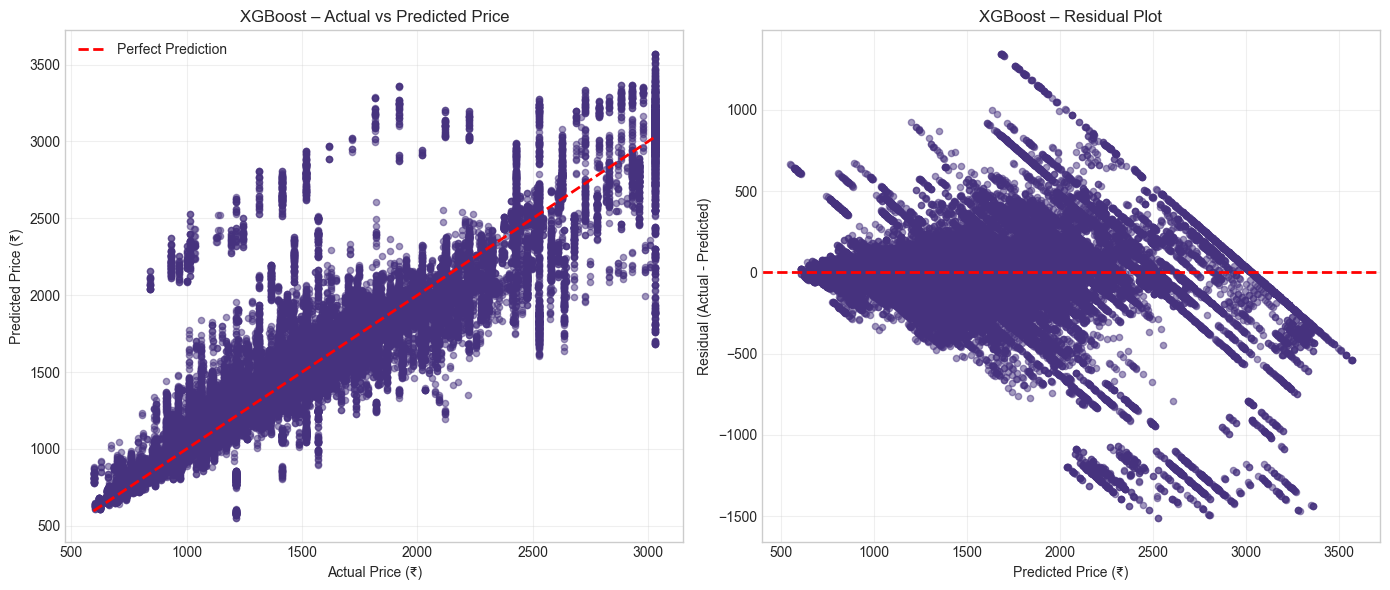

Evaluation, prediction table, and visualization complete.


In [14]:
# ────────────────────────────────────────────────────────────────
#     MODEL EVALUATION + VISUALIZATION + PREDICTION TABLE
# ────────────────────────────────────────────────────────────────

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

sns.set_style("whitegrid")

print("="*100)
print("MODEL EVALUATION & PREDICTION TABLE – Best Model")
print("="*100)

# ── Get predictions from best model ────────────────────────────────────────────
best_model = trainer.models[best_model_name]
y_pred_log = best_model.predict(X_test)

y_pred_orig = np.expm1(y_pred_log)
y_pred_orig = np.clip(y_pred_orig, 0, None)  # no negative prices

y_test_orig = np.expm1(y_test)

# ── Final metrics ──────────────────────────────────────────────────────────────
metrics = {
    'rmse_log': np.sqrt(mean_squared_error(y_test, y_pred_log)),
    'mae_log': mean_absolute_error(y_test, y_pred_log),
    'r2_log': r2_score(y_test, y_pred_log),
    'rmse_inr': np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),
    'mae_inr': mean_absolute_error(y_test_orig, y_pred_orig),
    'mape_pct': mean_absolute_percentage_error(y_test_orig, y_pred_orig) * 100
}

print("Final Performance Metrics (on Test Set):")
print(f"  R² (log scale)   : {metrics['r2_log']:.4f}")
print(f"  RMSE (₹)         : {metrics['rmse_inr']:.0f}")
print(f"  MAE (₹)          : {metrics['mae_inr']:.0f}")
print(f"  MAPE             : {metrics['mape_pct']:.2f}%")

# ── Prediction Table – 10 random test examples ────────────────────────────────
print("\n" + "-"*100)
print("PREDICTION TABLE – Real vs Model Predicted Prices")
print("10 random test seats scraped from the platform")
print("Left columns = actual scraped details (scrape time, journey day, departure time, etc.)")
print("Right columns = actual price vs model predicted price")
print("-"*100)

# Select 10 random positions in the TEST SET (0-based positions in X_test)
sample_pos = np.random.choice(len(X_test), size=10, replace=False)

# Get the corresponding original row indices from df_encoded
original_indices = X_test.index[sample_pos]

# Readable columns (including the three time columns you requested)
readable_cols = [
    'scraped_time',          # When the data was scraped/searched
    'journey_date',          # Day of the journey/booking
    'departure_time',        # Departure time of the bus
    'source_collection',     # From → To route
    'bus_type',
    'operator_name',
    'seat_name',
    'available_seats',
    'hours_to_departure',
    'journey_weekday',
    'is_AC'
]

# Filter to columns that exist
readable_cols = [c for c in readable_cols if c in df_encoded.columns]

# Fetch sample data using .loc with original indices (only valid ones)
valid_indices = original_indices[original_indices.isin(df_encoded.index)]

if len(valid_indices) == 0:
    print("Warning: No valid indices found in df_encoded – input columns will be empty")
    sample_data = pd.DataFrame(index=range(10))
else:
    sample_data = df_encoded.loc[valid_indices, readable_cols].reset_index(drop=True)

    # Pad with NaN if fewer than 10 (in case some indices missing)
    if len(sample_data) < 10:
        pad_df = pd.DataFrame(np.nan, index=range(10 - len(sample_data)), columns=sample_data.columns)
        sample_data = pd.concat([sample_data, pad_df], ignore_index=True)

# Format datetime columns for readability
for col in ['scraped_time', 'journey_date', 'departure_time']:
    if col in sample_data.columns and pd.api.types.is_datetime64_any_dtype(sample_data[col]):
        sample_data[col] = sample_data[col].dt.strftime('%Y-%m-%d %H:%M:%S')

# Create prediction results using array indexing (safe for numpy arrays)
# Force NumPy array positional indexing (safest)
y_test_orig_np  = np.asarray(y_test_orig)
y_pred_orig_np  = np.asarray(y_pred_orig)

results_df = pd.DataFrame({
    'Actual Price (₹)':   y_test_orig_np[sample_pos].round(0).astype(int),
    'Predicted Price (₹)': y_pred_orig_np[sample_pos].round(0).astype(int),
    'Difference (₹)':     (y_test_orig_np[sample_pos] - y_pred_orig_np[sample_pos]).round(0).astype(int),
    'Error %':            ((y_test_orig_np[sample_pos] - y_pred_orig_np[sample_pos]) / 
                           y_test_orig_np[sample_pos] * 100).round(1)
}, index=range(10))

# Combine input + predictions
results_df = pd.concat([sample_data, results_df], axis=1)

# Display the table
display(results_df)

# ── Visualizations ──────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter: Actual vs Predicted
axes[0].scatter(y_test_orig, y_pred_orig, alpha=0.5, s=20)
axes[0].plot([y_test_orig.min(), y_test_orig.max()],
             [y_test_orig.min(), y_test_orig.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel("Actual Price (₹)")
axes[0].set_ylabel("Predicted Price (₹)")
axes[0].set_title(f"{best_model_name} – Actual vs Predicted Price")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Residual plot
residuals = y_test_orig - y_pred_orig
axes[1].scatter(y_pred_orig, residuals, alpha=0.5, s=20)
axes[1].axhline(0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel("Predicted Price (₹)")
axes[1].set_ylabel("Residual (Actual - Predicted)")
axes[1].set_title(f"{best_model_name} – Residual Plot")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Evaluation, prediction table, and visualization complete.")

## Section 12: Feature Importance Analysis

FEATURE IMPORTANCE ANALYSIS – Best Model: XGBoost

Top 20 Most Important Features:
                  Feature  Importance
5      seat_is_horizontal    4.32e-01
0                   is_AC    1.61e-01
20       operator_name_le    6.31e-02
19               is_volvo    5.24e-02
18        is_premium_seat    3.93e-02
21            bus_type_le    3.58e-02
16       seats_sold_ratio    3.44e-02
8          duration_hours    2.91e-02
1         available_seats    2.74e-02
9         days_to_journey    2.49e-02
2            window_seats    2.25e-02
15  very_low_availability    1.87e-02
11        journey_weekday    1.24e-02
7      hours_to_departure    1.02e-02
23           seat_name_le    9.80e-03
14       low_availability    6.80e-03
17         is_lower_berth    6.30e-03
3           seat_is_upper    5.00e-03
6       seat_is_available    2.50e-03
12     journey_is_weekend    2.20e-03


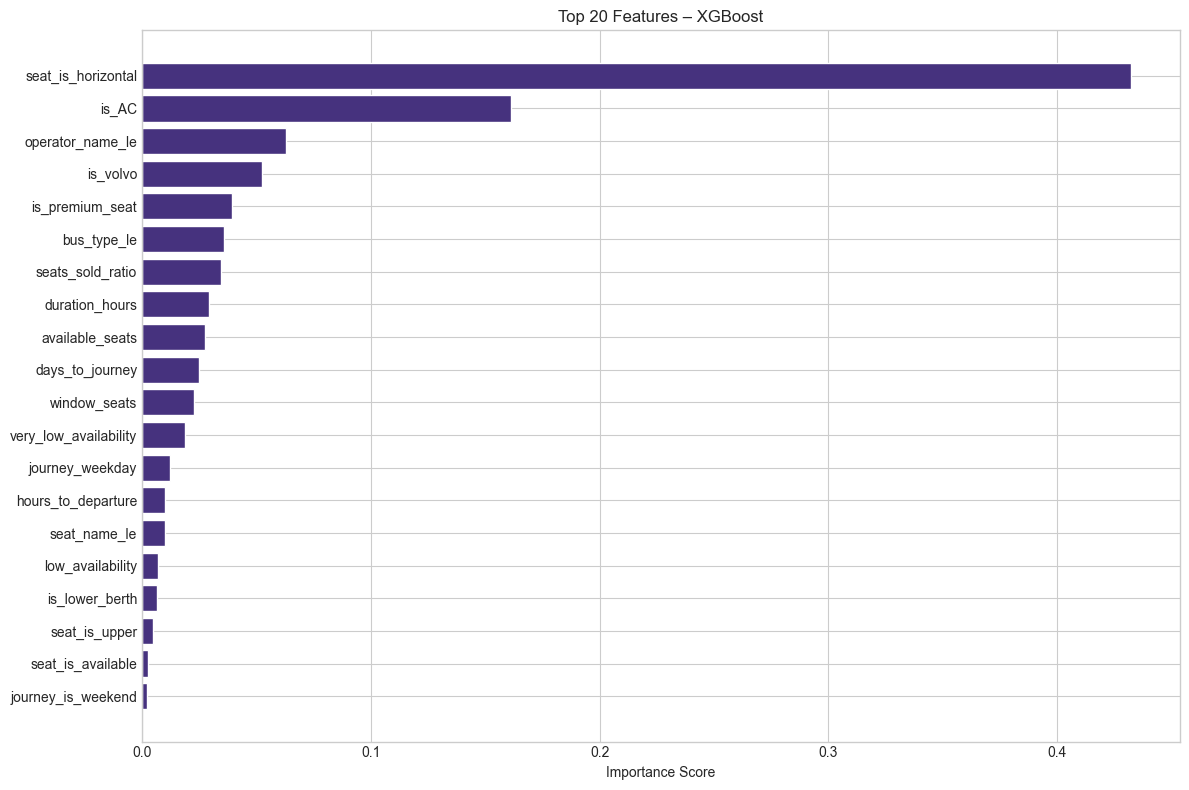


Key insights:
- Higher score = feature has bigger impact on price prediction
- Expect 'hours_to_departure', 'low_availability', 'seats_sold_ratio', etc. to rank high
Feature importance analysis complete.


In [15]:
# ────────────────────────────────────────────────────────────────
#               FEATURE IMPORTANCE ANALYSIS – Best Model
# ────────────────────────────────────────────────────────────────

import matplotlib.pyplot as plt
import pandas as pd

print("="*90)
print(f"FEATURE IMPORTANCE ANALYSIS – Best Model: {best_model_name}")
print("="*90)

# Get feature importance based on best model
if best_model_name == 'LightGBM':
    imp_values = trainer.models[best_model_name].feature_importance(importance_type='gain')
elif best_model_name == 'XGBoost':
    imp_values = trainer.models[best_model_name].feature_importances_
elif best_model_name == 'RandomForest':
    imp_values = trainer.models[best_model_name].feature_importances_
else:
    print("No importance available for selected model.")
    imp_values = None

if imp_values is not None:
    imp_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': imp_values
    }).sort_values('Importance', ascending=False)

    top_n = 20
    top_features = imp_df.head(top_n)

    print(f"\nTop {top_n} Most Important Features:")
    print(top_features.round(4))

    plt.figure(figsize=(12, 8))
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel('Importance Score')
    plt.title(f"Top {top_n} Features – {best_model_name}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("\nKey insights:")
    print("- Higher score = feature has bigger impact on price prediction")
    print("- Expect 'hours_to_departure', 'low_availability', 'seats_sold_ratio', etc. to rank high")

print("Feature importance analysis complete.")

## Section 13: Model Persistence

In [16]:
import joblib
import json
from datetime import datetime
import os
import wandb  # assuming it's already imported earlier

# Create a dedicated folder for saved models/artifacts
SAVE_DIR = "../models/saved_runs"
os.makedirs(SAVE_DIR, exist_ok=True)

# Timestamp for versioning
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print("="*80)
print("MODEL PERSISTENCE")
print("="*80)

# 1. Save best model (XGBoost / LightGBM / etc.)
model_filename = os.path.join(SAVE_DIR, f'bus_price_model_{best_model_name}_{timestamp}.pkl')
joblib.dump(trainer.best_model, model_filename)          # ← use trainer.best_model
print(f"Saved model: {model_filename}")

# 2. Save the CategoricalEncoder (full object)
encoder_filename = os.path.join(SAVE_DIR, f'categorical_encoder_{timestamp}.pkl')
joblib.dump(encoder, encoder_filename)
print(f"Saved categorical encoder: {encoder_filename}")
# 3. Save feature names – derived from X_train.columns (reliable & no extra variable needed)
features_filename = os.path.join(SAVE_DIR, f'feature_names_{timestamp}.json')

if 'X_train' not in globals() or not hasattr(X_train, 'columns'):
    print("Warning: X_train not found or has no .columns attribute → skipping feature names save")
    features_filename = None
else:
    feature_list = list(X_train.columns)
    with open(features_filename, 'w') as f:
        json.dump(feature_list, f, indent=2)
    print(f"Saved {len(feature_list)} feature names from X_train.columns: {features_filename}")

# 4. Save metrics (use the metrics from trainer)
metrics_filename = os.path.join(SAVE_DIR, f'model_metrics_{timestamp}.json')
metrics_data = {
    'model_name': trainer.best_model_name,
    'timestamp': timestamp,
    'metrics': trainer.scores[trainer.best_model_name],  # ← already has rmse_inr, mae_inr, mape_pct, etc.
    'training_samples': len(X_train),
    'testing_samples': len(X_test),
    'num_features': X_train.shape[1]
}
with open(metrics_filename, 'w') as f:
    
    json.dump(metrics_data, f, indent=2)
print(f"Saved metrics: {metrics_filename}")

# 5. Optional: Save feature engineering object (if 'fe' exists)
if 'fe' in globals() and hasattr(fe, '__class__'):  # safety check
    fe_filename = os.path.join(SAVE_DIR, f'feature_engineer_{timestamp}.pkl')
    joblib.dump(fe, fe_filename)
    print(f"Saved feature engineer: {fe_filename}")
else:
    fe_filename = None
    print("No 'fe' object found → skipping feature engineer save")

# 6. Log all artifacts to W&B (this still works locally)
artifact = wandb.Artifact(
    name=f"bus-price-predictor-v{timestamp}",
    type="model",
    description=f"Best model: {trainer.best_model_name} | "
                f"RMSE ₹: {trainer.scores[trainer.best_model_name]['rmse_inr']:.0f} | "
                f"MAPE: {trainer.scores[trainer.best_model_name]['mape_pct']:.2f}%"
)

artifact.add_file(model_filename)
artifact.add_file(encoder_filename)
artifact.add_file(features_filename)
artifact.add_file(metrics_filename)
if fe_filename:
    artifact.add_file(fe_filename)

wandb.log_artifact(artifact)
print(f"\nAll artifacts logged to W&B run: {wandb.run.url if wandb.run else 'No active run'}")

print("\n✓ Model persistence complete!")
print(f"Files saved in: {os.path.abspath(SAVE_DIR)}")
print("   You can now load them anytime for inference.")

MODEL PERSISTENCE
Saved model: ../models/saved_runs\bus_price_model_XGBoost_20260127_104450.pkl
Saved categorical encoder: ../models/saved_runs\categorical_encoder_20260127_104450.pkl
Saved 24 feature names from X_train.columns: ../models/saved_runs\feature_names_20260127_104450.json
Saved metrics: ../models/saved_runs\model_metrics_20260127_104450.json
Saved feature engineer: ../models/saved_runs\feature_engineer_20260127_104450.pkl

All artifacts logged to W&B run: https://wandb.ai/niharikareddy6902-arnsofttech/bus-price-prediction/runs/lhjrsc4o

✓ Model persistence complete!
Files saved in: c:\Users\Arn\Projects\dynamic-pricing\models\saved_runs
   You can now load them anytime for inference.


## Section 14: Sample Predictions

In [17]:
import numpy as np
import pandas as pd

print("="*120)
print("REAL DYNAMIC PRICING — Actual vs Predicted over Time (Same Trip)")
print("Using trips scraped multiple times in your historical data")
print("="*120)

# ── Settings ────────────────────────────────────────────────────────────────
min_scrapes = 3          # only show trips scraped at least this many times
num_trips_to_show = 3    # how many different trips to display

# Define what makes a "same trip" (adjust keys if needed)
trip_keys = [
    'operator_name',
    'source_collection',
    'bus_type',
    'journey_date',
    'departure_time',
    'seat_name'            # included for seat-level granularity
]

# ── Find repeated trips ─────────────────────────────────────────────────────
grouped = df_encoded.groupby(trip_keys).size().reset_index(name='scrape_count')
repeated = grouped[grouped['scrape_count'] >= min_scrapes].sort_values('scrape_count', ascending=False)

print(f"Trips scraped ≥ {min_scrapes} times: {len(repeated):,}")
if len(repeated) == 0:
    print("No trips meet the criteria — lower min_scrapes or check grouping keys.")
else:
    print(f"Showing {num_trips_to_show} random repeated trips...")

    # Pick random repeated trips
    selected_trips = repeated.sample(n=min(num_trips_to_show, len(repeated)), replace=False)

    for idx, row in selected_trips.iterrows():
        # Reconstruct mask for this exact trip
        mask = True
        for key in trip_keys:
            mask &= (df_encoded[key] == row[key])
        
        trip_data = df_encoded[mask].copy()
        trip_data = trip_data.sort_values('scraped_time')  # chronological
        
        actual_prices = trip_data['price'].values
        hours_left = trip_data['hours_to_departure'].values if 'hours_to_departure' in trip_data.columns else np.full(len(trip_data), np.nan)
        
        print(f"\nTrip {idx+1}:")
        print(f" Operator: {row['operator_name']}")
        print(f" Route: {row['source_collection']}")
        print(f" Bus Type: {row['bus_type']}")
        print(f" DOJ: {row['journey_date'].strftime('%Y-%m-%d %H:%M') if pd.notna(row['journey_date']) else 'N/A'}")
        print(f" Seat Name: {row.get('seat_name', 'N/A')}")
        print(f" Scraped {len(trip_data)} times")

        # Predict for each real scrape point
        preds = []
        for i in range(len(trip_data)):
            X_real = trip_data.iloc[[i]][X_test.columns]
            try:
                pred_log = trainer.best_model.predict(X_real)[0]
                pred_price = np.expm1(pred_log)
                pred_price = max(0, round(pred_price))
            except:
                pred_price = np.nan
            preds.append(pred_price)

        # Create comparison table with all major columns
        trip_df = pd.DataFrame({
            'Route': [row['source_collection']] * len(trip_data),
            'Bus Type': [row['bus_type']] * len(trip_data),
            'Seat Name': [row.get('seat_name', 'N/A')] * len(trip_data),
            'DOJ': [row['journey_date'].strftime('%Y-%m-%d %H:%M') if pd.notna(row['journey_date']) else 'N/A'] * len(trip_data),
            'Search Time (scraped)': trip_data['scraped_time'].dt.strftime('%Y-%m-%d %H:%M'),
            'Hours Left': hours_left.round(1),
            'Actual Price (₹)': [int(p) if not np.isnan(p) else 'N/A' for p in actual_prices],
            'Predicted Price (₹)': [int(p) if not np.isnan(p) else 'Error' for p in preds],
            'Diff (₹)': [int(p - a) if not np.isnan(p) and not np.isnan(a) else 'N/A' for p,a in zip(preds, actual_prices)],
            'Diff %': [round((p - a)/a*100, 1) if not np.isnan(p) and not np.isnan(a) and a != 0 else 'N/A' for p,a in zip(preds, actual_prices)]
        })

        # Plain formatting — no coloring
        display(trip_df.style.format({
            'Actual Price (₹)': '{:d}',
            'Predicted Price (₹)': '{:d}',
            'Diff (₹)': '{:+d}',
            'Diff %': '{:+.1f}%',
            'Hours Left': '{:.1f}'
        }))

print("\nDone. Re-run cell for different random repeated trips.")

REAL DYNAMIC PRICING — Actual vs Predicted over Time (Same Trip)
Using trips scraped multiple times in your historical data
Trips scraped ≥ 3 times: 34,459
Showing 3 random repeated trips...

Trip 11395:
 Operator: IntrCity SmartBus
 Route: hyderabad_bangalore
 Bus Type: A/C Sleeper (2+1)
 DOJ: 2025-12-13 00:00
 Seat Name: 2LB
 Scraped 26 times


,Route,Bus Type,Seat Name,DOJ,Search Time (scraped),Hours Left,Actual Price (₹),Predicted Price (₹),Diff (₹),Diff %
157824,hyderabad_bangalore,A/C Sleeper (2+1),2LB,2025-12-13 00:00,2025-12-07 04:36,166.1,1282,1294,+12,+0.9%
94234,hyderabad_bangalore,A/C Sleeper (2+1),2LB,2025-12-13 00:00,2025-12-07 05:06,165.6,1282,1258,-24,-1.9%
77517,hyderabad_bangalore,A/C Sleeper (2+1),2LB,2025-12-13 00:00,2025-12-07 05:35,165.1,1282,1258,-24,-1.9%
181799,hyderabad_bangalore,A/C Sleeper (2+1),2LB,2025-12-13 00:00,2025-12-07 06:05,164.6,1282,1259,-23,-1.8%
174696,hyderabad_bangalore,A/C Sleeper (2+1),2LB,2025-12-13 00:00,2025-12-07 06:35,164.1,1282,1257,-25,-2.0%
37786,hyderabad_bangalore,A/C Sleeper (2+1),2LB,2025-12-13 00:00,2025-12-07 07:08,163.5,1282,1253,-29,-2.3%
47799,hyderabad_bangalore,A/C Sleeper (2+1),2LB,2025-12-13 00:00,2025-12-07 08:35,162.1,1232,1231,-1,-0.1%
55946,hyderabad_bangalore,A/C Sleeper (2+1),2LB,2025-12-13 00:00,2025-12-07 09:06,161.6,1232,1225,-7,-0.6%
189075,hyderabad_bangalore,A/C Sleeper (2+1),2LB,2025-12-13 00:00,2025-12-07 09:36,161.1,1232,1226,-6,-0.5%
169788,hyderabad_bangalore,A/C Sleeper (2+1),2LB,2025-12-13 00:00,2025-12-07 10:06,160.6,1232,1226,-6,-0.5%



Trip 11110:
 Operator: IntrCity SmartBus
 Route: hyderabad_bangalore
 Bus Type: A/C Seater / Sleeper (2+1)
 DOJ: 2025-12-13 00:00
 Seat Name: 2F
 Scraped 53 times


,Route,Bus Type,Seat Name,DOJ,Search Time (scraped),Hours Left,Actual Price (₹),Predicted Price (₹),Diff (₹),Diff %
150828,hyderabad_bangalore,A/C Seater / Sleeper (2+1),2F,2025-12-13 00:00,2025-12-07 04:36,164.1,808,820,+12,+1.5%
151325,hyderabad_bangalore,A/C Seater / Sleeper (2+1),2F,2025-12-13 00:00,2025-12-07 04:36,164.1,1262,1259,-3,-0.2%
92020,hyderabad_bangalore,A/C Seater / Sleeper (2+1),2F,2025-12-13 00:00,2025-12-07 05:06,163.6,1262,1255,-7,-0.6%
91219,hyderabad_bangalore,A/C Seater / Sleeper (2+1),2F,2025-12-13 00:00,2025-12-07 05:06,163.6,808,820,+12,+1.5%
80544,hyderabad_bangalore,A/C Seater / Sleeper (2+1),2F,2025-12-13 00:00,2025-12-07 05:35,163.1,808,820,+12,+1.5%
79088,hyderabad_bangalore,A/C Seater / Sleeper (2+1),2F,2025-12-13 00:00,2025-12-07 05:35,163.1,1262,1255,-7,-0.6%
182317,hyderabad_bangalore,A/C Seater / Sleeper (2+1),2F,2025-12-13 00:00,2025-12-07 06:05,162.6,808,816,+8,+1.0%
182651,hyderabad_bangalore,A/C Seater / Sleeper (2+1),2F,2025-12-13 00:00,2025-12-07 06:05,162.6,1262,1248,-14,-1.1%
175522,hyderabad_bangalore,A/C Seater / Sleeper (2+1),2F,2025-12-13 00:00,2025-12-07 06:35,162.1,1262,1249,-13,-1.0%
173889,hyderabad_bangalore,A/C Seater / Sleeper (2+1),2F,2025-12-13 00:00,2025-12-07 06:35,162.1,808,818,+10,+1.2%



Trip 3147:
 Operator: BigBus
 Route: hyderabad_bangalore
 Bus Type: Bharat Benz A/C Sleeper (2+1)
 DOJ: 2025-12-13 00:00
 Seat Name: 8U
 Scraped 48 times


,Route,Bus Type,Seat Name,DOJ,Search Time (scraped),Hours Left,Actual Price (₹),Predicted Price (₹),Diff (₹),Diff %
150376,hyderabad_bangalore,Bharat Benz A/C Sleeper (2+1),8U,2025-12-13 00:00,2025-12-07 04:36,160.9,2785,2736,-49,-1.8%
152986,hyderabad_bangalore,Bharat Benz A/C Sleeper (2+1),8U,2025-12-13 00:00,2025-12-07 04:36,160.9,1213,1333,+120,+9.9%
95305,hyderabad_bangalore,Bharat Benz A/C Sleeper (2+1),8U,2025-12-13 00:00,2025-12-07 05:06,160.4,2785,2772,-13,-0.5%
90839,hyderabad_bangalore,Bharat Benz A/C Sleeper (2+1),8U,2025-12-13 00:00,2025-12-07 05:06,160.4,1213,1319,+106,+8.7%
78445,hyderabad_bangalore,Bharat Benz A/C Sleeper (2+1),8U,2025-12-13 00:00,2025-12-07 05:35,159.9,2785,2769,-16,-0.6%
183258,hyderabad_bangalore,Bharat Benz A/C Sleeper (2+1),8U,2025-12-13 00:00,2025-12-07 06:05,159.4,1213,1313,+100,+8.2%
187380,hyderabad_bangalore,Bharat Benz A/C Sleeper (2+1),8U,2025-12-13 00:00,2025-12-07 06:05,159.4,2785,2769,-16,-0.6%
176137,hyderabad_bangalore,Bharat Benz A/C Sleeper (2+1),8U,2025-12-13 00:00,2025-12-07 06:35,158.9,1213,1323,+110,+9.1%
176932,hyderabad_bangalore,Bharat Benz A/C Sleeper (2+1),8U,2025-12-13 00:00,2025-12-07 06:35,158.9,2785,2769,-16,-0.6%
44346,hyderabad_bangalore,Bharat Benz A/C Sleeper (2+1),8U,2025-12-13 00:00,2025-12-07 07:08,158.4,2785,2777,-8,-0.3%



Done. Re-run cell for different random repeated trips.
